# Visualizing transformers

During this lab you will get more intuition about how attention mechanism works in practice. You will learn how to get some statistics about the model and how to visualize the attention based on the pretrained DialoGPT model.

In [ ]:
# imports and global variables
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
import csv
import urllib.request

DEVICE = 'cpu'

## The Language Model

Let's use the DialoGPT medium model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-medium')
model.eval()

Let's investigate deeper how the model looks like:

In [ ]:
# prints model's architecture
print(model)

In [ ]:
# investigating model parameters

parameters_count = 0

for name, param in model.named_parameters():
    print(name, param.size())
    parameters_count += np.prod(param.size())

print('Total number of parameters:', parameters_count)

Some important facts about the architecture:
- over 354 mln parameters
- it uses the same architecture as GPT-2
- there are two embedding layers - wte and wpe, the word token embedding and the word position embedding
- there are 23 'GPT-2 Blocks', which are usually called decoder blocks
- each block consists of: normalization layer #1, attention layer, normalization layer and multi-layer perceptron (feed-forward network)
- the model's last layer, often called 'head', is a linear layer

## Attention visualization

The easiest way to get some intuition about how the model works is to look at the attention layers.

In [ ]:
# let's prepare a sample input
sample_text = "John would like to have a new computer. It would be much faster than his current one."
tokenized_text = tokenizer.tokenize(sample_text)
encoded_text = tokenizer.encode(sample_text, return_tensors='pt')

print(tokenized_text)

tokenized_text = [token.replace('Ġ', '') for token in tokenized_text] # let's ignore the Ġ (whitespace) symbol

print('Tokens:', tokenized_text) # tokens' string representation, will be useful for plotting
print('Token ids:', encoded_text)

In [ ]:
model_output = model(encoded_text, output_attentions=True)

print(model_output.attentions)

#### What do those values mean?

*(You can skip this part if you understand what those values are)*

The self-attention mechanism works as follows:
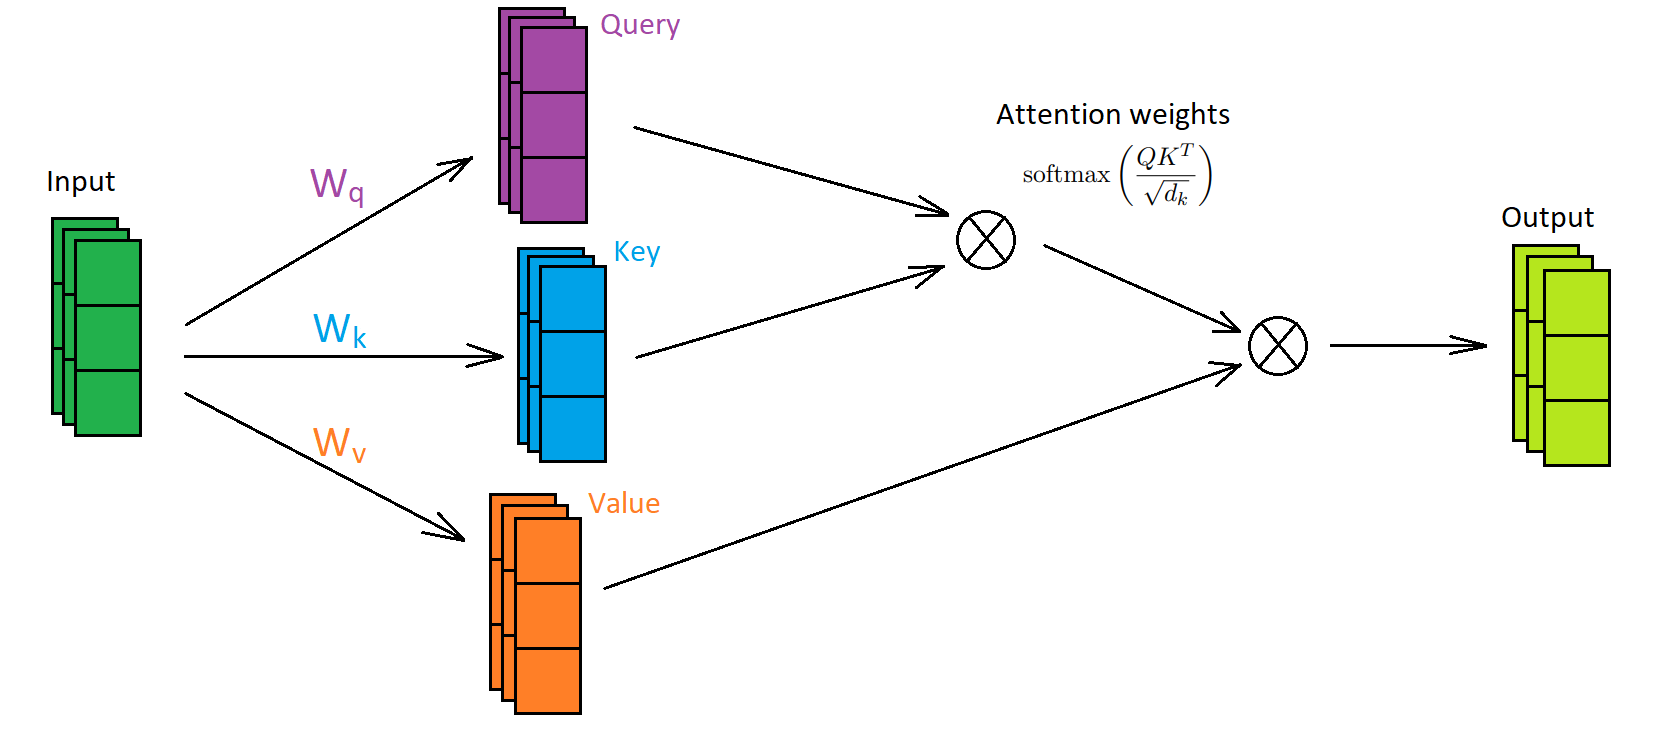



First, the input values for the attention layer are multiplied by matrices $W_q$, $W_k$ and $W_v$ to obtain queries $Q$, keys $K$ and values $V$. Then the attention weights are calculated with the equation $A = softmax(\frac{QK^T}{\sqrt{d_k}})$ and then are multiplied with $V$ to obtain the output $O = AV$.

The attention weights determine the importance of every input token in calculations of the output token. Those are the values in the `model_output.attentions`.

Let's plot those values and see what is happening in each attention layer. Write a function `illustrate_attention(tokens, attention_outputs, layer, heads, token_id)` that illustrates the attention outputs for a chosen attention layer, attention heads and token.

Below there is a `generate_colormap` function that generates `matplotlib`'s colormap from `starting_color` to `target_color` and some ready-to-use colormaps. Feel free to generate your own colors. Take a look at the provided plotting example for some inspirations.

In [ ]:
# Colormaps

def generate_colormap(starting_color, target_color):
    starting_color = tuple(x / 255 for x in starting_color)
    target_color = tuple(x / 255 for x in target_color)

    cdict = {
        'red': [
                  (0.0, starting_color[0], starting_color[0]),
                  (1.0, target_color[0], target_color[0])
               ],

        'green': [
                    (0.0, starting_color[1], starting_color[1]),
                    (1.0, target_color[1], target_color[1])
                 ],

        'blue': [
                   (0.0, starting_color[2], starting_color[2]),
                   (1.0, target_color[2], target_color[2])
                ]
    }

    return mcolors.LinearSegmentedColormap('cmp', segmentdata=cdict, N=256)

def plot_colormap(colormap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    plt.imshow(gradient, aspect=10, cmap=colormap)
    plt.show()

suggested_colormaps = [
    plt.get_cmap('Reds'),
    plt.get_cmap('Greens'),
    plt.get_cmap('Blues'),
    plt.get_cmap('Oranges'),
    plt.get_cmap('Purples'),
    generate_colormap((242, 255, 230), (74, 153, 0)), # light green
    generate_colormap((255, 238, 230), (204, 68, 0)), # salmonish
    generate_colormap((230, 255, 255), (0, 153, 153)), # cyan
    generate_colormap((243, 230, 255), (105, 0, 204)), # lilac
    generate_colormap((230, 255, 242), (0, 153, 74)), # jade
    generate_colormap((249, 242, 236), (136, 86, 43)), # brown
    generate_colormap((230, 247, 255), (0, 122, 179)), # light blue
    generate_colormap((255, 204, 224), (153, 0, 61)), # magenta
    generate_colormap((235, 235, 224), (93, 93, 60)), # olive
    plt.get_cmap('Greys'),
]

for cmap in suggested_colormaps:
    plot_colormap(cmap)

In [ ]:
# Suggestions for generating visualizations for attention values

labels = ['This', 'is', 'some', 'sample', 'text']
target_label = 'text'
attention_values = np.array([
    [0.1, 0.3, 0.0, 0.4, 0.2],
    [0.0, 0.3, 0.5, 0.2, 0.1],
]) # those values are completely random and do not mean anything

heads = attention_values.shape[0]

fig, ax = plt.subplots(
    heads,
    1,
    figsize=(3.5, 0.8 * heads),
    sharey='row',
    sharex='col'
)

fig.suptitle(f'Attention for token `{target_label}`')
fig.set_dpi(200)

for i in range(heads):
    ax[i].imshow(attention_values[i:i+1], cmap=suggested_colormaps[i], vmin=0, vmax=1)
    ax[i].axis('off')

    for j in range(len(labels)):
        text = ax[i].text(j, 0, labels[j], fontsize='small', ha="center", va="center", color='black' if attention_values[i, j] < 0.5 else 'white')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
def illustrate_attention(tokens, attention_outputs, layer, heads, token_id):
    """
        Plots the results of the attention mechanism in the chosen attention layer `layer` and heads `heads`
        for token `token_id`.

        Arguments:
            - tokens - list of strings with token labels
            - attention_outputs - the `attentions` parameter of model's output object
            - layer - the id of the chosen attention layer
            - heads - the list of ids of the chosen attention heads
            - token_id - the id of the chosen token
    """

    # TODO

illustrate_attention(tokenized_text, model_output.attentions, 4, list(range(0, 15)), 2)

Try finding inputs with interesting attention values. See how the attention looks in a different models, e.g. pretrained GPT-2 or untrained GPT-2.

In [ ]:
# TODO

## Input saliency

Another interesting idea is to try to determine which input tokens contribute to the next token predictions. According to the publication "A Diagnostic Study of Explainability Techniques for Text Classification" by Atanasova et al. (https://arxiv.org/pdf/2009.13295.pdf), a gradient-based input saliency is a viable method for visualizing language models.

The language model returns logits that form a probability distribution over all tokens in the vocabulary that predicts the next token. Using the backpropagation method, we can calculate the gradient of a chosen logit with respect to the input. The gradients give us some intuition about the importance of the input tokens - we assume that if the gradient is large then changing the input token will drastically change the output value, so it should have an influence on the output. The token's importance value is defined as the L2 norm of the element-wise multiplication of the gradient vector and the token's embedding.

#### Torch's Autograd

Autograd is a tool performing automatic differentiation in PyTorch. See [this article](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/) for a great explaination how Autograd works.

#### Torch Forward and Backward hooks

Torch provides a very useful functionality called hooks. The hook is a function that can be registered on a `Tensor` or `nn.Module` and will be called each time the `forward` or `backward` function of the `torch.Autograd.Function` of the registered object is executed. They are useful to get values of gradients with respect to some specific layer's weights.

The forward hook executes a function with signature: `(module, input, output) -> None` where `module` is the registered module, `input` is the input Tensor, output is the `module`'s output Tensor.

The backward hook executes a function with signature: `(module, input_grad, output_grad) -> None or Tensor` where `module` is the registered module, `input_grad` is the gradient with respect to the input, `output_grad` is the gradient with respect to the output. The hook may return a `Tensor` that replaces the `input_grad` in later backpropagation steps, but we won't need that today.

#### The algorithm

We can generate input saliency with the following steps:
1. Register backward hook on the embedding layer's `Module` to get gradients with respect to the embedded input tokens (embedding layer output)
2. Register a forward hook on the embedding layer's `Module` to get the values of the embedded tokens
3. Run `model.forward()` on a chosen input and generate the logits for the next token
4. Choose a logit representing a token you are interested in and call `backward()`
5. Calculate L2 norm of the element-wise multiplication of values obtained from forward and backward hooks - it's the input saliency


In [ ]:
# let's print the model's architecture once again. What is the name of the embedding layer?
print(model)

In [ ]:
# let's prepare a sample input
sample_text = "My favourite animal is the"
tokenized_text = tokenizer.tokenize(sample_text)
encoded_text = tokenizer.encode(sample_text, return_tensors='pt')

print(tokenized_text)

tokenized_text = [token.replace('Ġ', '') for token in tokenized_text] # let's ignore the Ġ (whitespace) symbol

print('Tokens:', tokenized_text) # tokens' string representation, will be useful for plotting
print('Token ids:', encoded_text)

In [ ]:
# example filled code

def calc_saliency(model, input_token_ids):
    torch.enable_grad()
    model.eval()

    embedded_input_tokens = []
    embedding_layer_gradients = []

    # 1. register a backward hook on the embedding layer's Module to get gradients with respect to the embedded input tokens
    embedding_layer = # TODO - set it to the model's embedding layer

    def backward_hook(module, grad_input, grad_output):
        embedding_layer_gradients.append(grad_output[0].clone().detach())

    backward_hook_handle = embedding_layer.register_backward_hook(backward_hook)

    # 2. register a forward hook on the embedding layer's Module to get the values of the embedded tokens
    def forward_hook(module, inputs, outputs):
        embedded_input_tokens.append(outputs.clone().detach())

    forward_hook_handle = embedding_layer.register_forward_hook(forward_hook)

    # 3. Run `model.forward()` on a chosen input and generate the logits for the next token
    model.zero_grad() # set gradients to 0
    model_output = model(input_token_ids)
    next_token_logits = model_output.logits[0, -1, :]

    # 4. Choose a logit representing a token you are interested in and call backward()
    predicted_token = torch.argmax(next_token_logits.detach()) # detach to ignore computing gradients
    next_token_logits[predicted_token].backward()

    # remove hooks
    backward_hook_handle.remove()
    forward_hook_handle.remove()

    embedded_input_tokens = embedded_input_tokens[0][0]
    embedding_layer_gradients = embedding_layer_gradients[0][0]

    # 5. Calculate L2 norm of the element-wise multiplication of values obtained from forward and backward hooks - it's the input saliency
    saliency_grad = # TODO - get the L2 norm (\sqrt(v^Tv)) of the input embeddings (dim 1) and normalize the obtained scores (divide by sum of token scores)

    return saliency_grad, predicted_token

input_saliency_map, predicted_token = calc_saliency(model, encoded_text)

print(input_saliency_map)
print(tokenizer.decode(predicted_token))

In [ ]:
# TODO - implement a function that plots the results in the readable way (similarly to illustrate_attention)
# then try out different inputs and analyze the results. You don't have to always choose the token with the largest logit
# for backpropagation, feel free to change it.